<h1>Тестовое задание на позицию Junior Data Engineer</h1><br> <b>Задача</b> - создать функцию на языке Python, которая для указанного произвольного пользователя берет его историю шагов и на выходе  отдает список размеченных дней: неизвестно, обычный или необычный.<br><br><b>Критерий</b> - это попадание в ожидание среднестатистического человека о работе “умной” системы, которая смотрит его данные и решает, что сегодня обычный или необычный день.

Данную задачу можно свести к <u>поиску аномальных данных</u> , т.е. поиску тех данных, которые не укладываются в привычную картину. Достаточно стабильным с точки зрения качества является метод изолирующего леса (Isolation Forest).

<b>В основе алгоритма Isolation Forest лежит тенденция к тому, что аномальные "точки" легче отделить от остальной части выборки по сравнению с нормальными точками.</b><br> Изоляционный лес построен на основе деревьев решений. В этих деревьях разделы создаются сначала случайным образом выбирая объект, а затем выбирая случайное значение разделения между минимальным и максимальным значением выбранного объекта. Повторюсь, что выбросы встречаются реже, чем обычные наблюдения, и отличаются от них с точки зрения значений (они находятся дальше от обычных наблюдений в пространстве признаков). Вот почему при использовании такого случайного разбиения они должны быть идентифицированы ближе к корню дерева (более короткая средняя длина пути, т.е. число ребер, которые должно пройти наблюдение в дереве, идущем от корня к конечному узлу), с меньшим количеством расщеплений.

В качестве альтернативы можно рассмотреть метрические методы, например используя перцентили заданного уровня, однако такой подход будет менее точным, т.к. он основывается на пороговых значениях и будет давать сбой на более-менее равномерных данных.

Также имеет смысл подумать над использованием закона Вебера — Фехнера — эмпирический психофизиологический закон, заключающийся в том, что интенсивность ощущения чего-либо прямо пропорциональна логарифму интенсивности раздражителя.

<b>Шаг 1:</b> Импортируем зависимости и отключаем предупреждения.

In [16]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from dateutil.parser import parse
from sklearn.ensemble import IsolationForest

<b>Шаг 2:</b> Создаем функцию для загрузки csv-файла, фильтрации данных по заданному user_id и подсчета суммарного числа шагов в разрезе по дням.<br> P.S. В качестве времени используется локальное время пользователя. В дальнейшем можно добавить проверку на наличие строк с началом в одном дне, и окончанием в следующем.

In [9]:
def getUserSteps(csv_path, uid):
    csv = pd.read_csv(csv_path, sep=',')
    csv = csv[csv['User ID'] == uid]
    
    csv['Time End Local Tz'  ] = csv['Time End Local Tz'  ].apply(lambda x: parse(x))
    csv['Time Start Local Tz'] = csv['Time Start Local Tz'].apply(lambda x: parse(x))
    csv['Date'] = csv['Time Start Local Tz'].apply(lambda x: x.date())

    return csv.groupby(['Date'])['Value'].sum().reset_index()   

<b>Шаг 3:</b> Загружаем данные и выводим первые 5 записей.

In [20]:
df = getUserSteps("D:/Dowloads/query_result_2019-12-24T07_29_06.659397Z.csv",2166)
df.head()

,Date,Value
0,2019-05-02,12977.0
1,2019-05-03,17003.0
2,2019-05-04,14312.0
3,2019-05-05,11124.0
4,2019-05-06,7467.0


<b>Шаг 4:</b> Создаем функцию для обучения модели IsolationForest и получения предсказания об аномальных точках.

In [21]:
def fitIsolationForest(n_estimators=100, max_samples='auto', contamination=float(.15), n_jobs=-1, random_state=1618):
    
    to_model_columns=df.columns[1:2]# колонки с метриками(в данном случае у нас одна метрика, но есть возможность расширения)

    clf=IsolationForest(n_estimators=n_estimators, max_samples=max_samples, contamination=contamination,  n_jobs=n_jobs, random_state=random_state)
    clf.fit(df[to_model_columns])
    
    pred = clf.predict(df[to_model_columns])
    df['Anomaly']=pred 
    
    #Выводим информацию о найденных аномалиях в данных
    outliers = df.loc[df['Anomaly']==-1]
    outlier_index = list(outliers.index)
    print('Abnormal Indices:', outlier_index)
    print('Anomaly counts:\n', df['Anomaly'].value_counts())

<b>Шаг 5:</b> Обучяем модель IsolationForest, получаем предсказания и добавляем их в исходную таблицу.

In [23]:
fitIsolationForest()

Abnormal Indices: [4, 8, 16, 21, 25, 29, 33, 52, 68, 78, 79, 80, 91, 92, 93, 97]
Anomaly counts:
  1    88
-1    16
Name: Anomaly, dtype: int64


D:\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


<b>Шаг 6:</b> Создаем функцию для визуализации данных.

In [25]:
def Plot():
    fig, ax = plt.subplots()
    
    x=df['Date'].values.reshape(-1, 1) 
    y=df['Value'].values.reshape(-1, 1)
    marks=df['Anomaly'].values 
    
    colors = np.where(marks==1,'g','r') 
    
    ax.scatter(x, y, c=colors, s=15, linewidth=0)
    
    ax.set_facecolor('black')
    ax.set_title('User steps count')
    
    fig.set_figwidth(12)   
    fig.set_figheight(8)
    
    plt.show()

<b>Шаг 7:</b> Выводим график

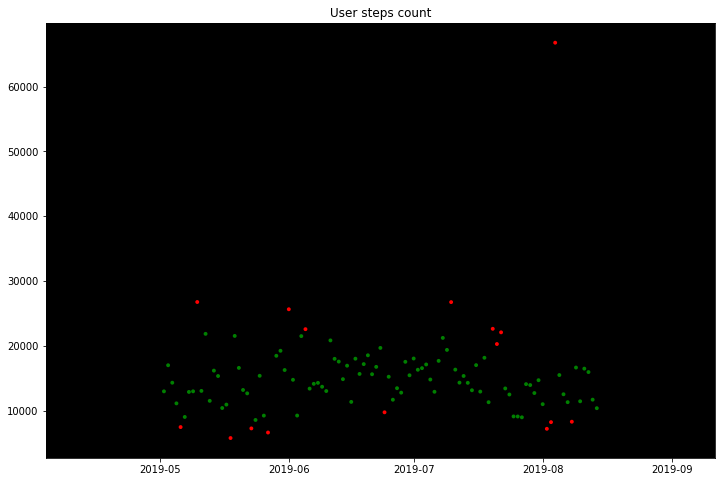

In [26]:
Plot()